In [68]:
import pandas as pd
import xmltodict
import zipfile
import numpy as np
from matplotlib.dates import DateFormatter

In [3]:
import zipfile
import pandas as pd
import xmltodict

def new_data_parsing(zip_path:str = 'export.zip' ,save_csv_path:str = 'health_data.csv', save:bool = True) -> pd.DataFrame:
    """
    This function performs the following steps in an Apple Health export
    Unzip, parse xml and save as a csv file

    :param zip_path: the path to your export zip file
    :param save_csv_path: the path to save your csv. Must end in .csv
    :param save: Bool to determine if you wish to save the csv or just return it
    :return: Returns a data frame containing the parsed health data
    """

    ## Extracting zip
    with zipfile.ZipFile(zip_path,"r") as zip_ref:
        zip_ref.extractall()

    ## Parsing xml
    input_path = 'apple_health_export/export.xml'
    with open(input_path, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())

    ## Selecting only relevant dict keys
    records_list = input_data['HealthData']['Record']

    ## Creating and saving csv
    df = pd.DataFrame(records_list)
    if save:
        df.to_csv(save_csv_path,index=False, sep=';')

    return df

In [38]:
df = pd.read_csv('health_data.csv',sep=';')

C:\Users\gabrielcassimiro\AppData\Local\Temp\ipykernel_12444\4025945638.py:1: DtypeWarning: Columns (7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('health_data.csv',sep=';')


In [39]:
df.head()

,@type,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,@value,MetadataEntry,@device,HeartRateVariabilityMetadataList
0,HKQuantityTypeIdentifierDietaryWater,Lifesum,2,mL,2020-12-05 02:07:11 -0300,2020-12-05 02:07:11 -0300,2020-12-05 02:07:11 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN
1,HKQuantityTypeIdentifierDietaryWater,Lifesum,3,mL,2020-06-16 16:07:10 -0300,2020-06-16 16:07:09 -0300,2020-06-16 16:07:09 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN
2,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-17 15:55:43 -0300,2020-06-17 15:55:42 -0300,2020-06-17 15:55:42 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN
3,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-19 20:02:19 -0300,2020-06-19 20:02:19 -0300,2020-06-19 20:02:19 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN
4,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-27 15:30:24 -0300,2020-06-27 15:30:24 -0300,2020-06-27 15:30:24 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN


In [40]:
df['@type'].value_counts()

HKQuantityTypeIdentifierActiveEnergyBurned                1430914
HKQuantityTypeIdentifierHeartRate                          343706
HKQuantityTypeIdentifierBasalEnergyBurned                  320805
HKQuantityTypeIdentifierDistanceWalkingRunning             274731
HKQuantityTypeIdentifierStepCount                          262952
HKQuantityTypeIdentifierAppleExerciseTime                   46910
HKQuantityTypeIdentifierAppleStandTime                      37852
HKCategoryTypeIdentifierAppleStandHour                      26889
HKQuantityTypeIdentifierEnvironmentalAudioExposure          22457
HKQuantityTypeIdentifierWalkingSpeed                         8961
HKQuantityTypeIdentifierWalkingStepLength                    8949
HKQuantityTypeIdentifierFlightsClimbed                       8477
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage       6846
HKQuantityTypeIdentifierHeadphoneAudioExposure               4313
HKCategoryTypeIdentifierSleepAnalysis                        3897
HKQuantity

In [41]:
df.dtypes

@type                               object
@sourceName                         object
@sourceVersion                      object
@unit                               object
@creationDate                       object
@startDate                          object
@endDate                            object
@value                              object
MetadataEntry                       object
@device                             object
HeartRateVariabilityMetadataList    object
dtype: object

In [42]:
df['@sourceName'].value_counts()

AppleÂ Watch de Gabriel        2233261
Gabrielâ€™s AppleÂ Watch        425216
iPhone de Gabriel Cassimiro     159725
AutoSleep                         1368
Lifesum                           1347
Forest                             158
Clock                              146
Renpho                             124
Headspace                           33
Health                               4
Name: @sourceName, dtype: int64

In [44]:
def data_preprocessing(df: pd.DataFrame, health_data_type: str) -> pd.DataFrame:
    """
    Preprocess data frame fixing dates, data types and grouping by day.

    :param df: the data frame to be processed
    :param health_data_type: @type id in the health database
    :return: preprocessed data frame
    """

    ## Filtering selected @type
    df = df[df['@type'] == health_data_type]

    ## Transform dates to DateTime format
    df['date'] = pd.to_datetime(df['@startDate'],
                                          format='%Y-%m-%d %H:%M:%S %z',)
    ## Transform values to float
    df['@value'] =df['@value'].astype('float')


    ## return grouped values for Burned Energy for each day
    return df.groupby(pd.Grouper(key='date', freq='D'))['@value'].sum().reset_index()

df = data_preprocessing(df,'HKQuantityTypeIdentifierActiveEnergyBurned')

C:\Users\gabrielcassimiro\AppData\Local\Temp\ipykernel_12444\3693953007.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['@startDate'],
C:\Users\gabrielcassimiro\AppData\Local\Temp\ipykernel_12444\3693953007.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['@value'] =df['@value'].astype('float')


In [45]:
df.head()

,date,@value
0,2017-09-24 00:00:00-03:00,47.295
1,2017-09-25 00:00:00-03:00,573.783
2,2017-09-26 00:00:00-03:00,651.558
3,2017-09-27 00:00:00-03:00,586.813
4,2017-09-28 00:00:00-03:00,352.367


In [46]:
df.dtypes

date      datetime64[ns, pytz.FixedOffset(-180)]
@value                                   float64
dtype: object

In [47]:
df.isna().sum()

date      0
@value    0
dtype: int64

In [48]:
(df['@value'] == 0).sum()

104

In [49]:
(df['@value'] <= 50).sum()

147

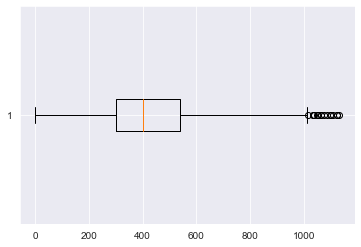

In [65]:
import matplotlib.pyplot as plt

plt.boxplot(df['@value'], vert=False,whis=2)
plt.savefig('box_plot.png', transparent=True)

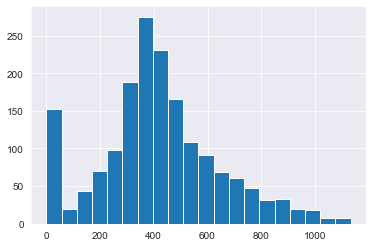

In [62]:
plt.hist(df['@value'],bins=20)
plt.savefig('histogram.png', transparent=True)
# plt.show()

In [60]:
print(pd.date_range(start=df.date.min(), end=df.date.max()).difference(df.set_index('date').index))

DatetimeIndex([], dtype='datetime64[ns, pytz.FixedOffset(-180)]', freq='D')


In [54]:
print(df.date.min(),df.date.max())

2017-09-24 00:00:00-03:00 2022-06-27 00:00:00-03:00


In [61]:
df.shape

(1738, 2)

In [66]:
df

,date,@value
0,2017-09-24 00:00:00-03:00,47.295
1,2017-09-25 00:00:00-03:00,573.783
2,2017-09-26 00:00:00-03:00,651.558
3,2017-09-27 00:00:00-03:00,586.813
4,2017-09-28 00:00:00-03:00,352.367
...,...,...
1733,2022-06-23 00:00:00-03:00,1065.173
1734,2022-06-24 00:00:00-03:00,1006.606
1735,2022-06-25 00:00:00-03:00,512.258
1736,2022-06-26 00:00:00-03:00,713.598


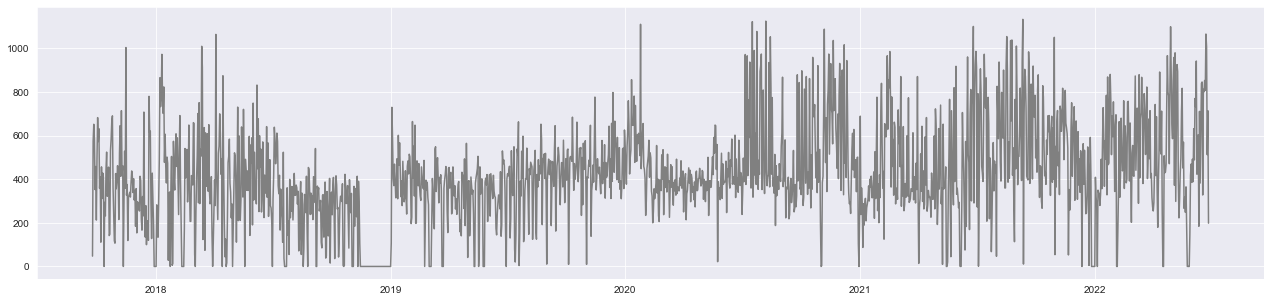

In [69]:
date_form = DateFormatter("%d-%b")

fig, ax = plt.subplots(figsize=(22, 5))
plt.plot(df.date,df['@value'], label='Real', color='gray')

In [38]:
# import statsmodels.api as sm
# df = df.copy()
# df = df.sort_values('date').set_index('date')
#
#
# decomposition = sm.tsa.seasonal_decompose(df, model='additive', period=1)
# decomposition.plot();